<ipython-input-2-20fb3f8ac66e>:51: ComplexWarning: Casting complex values to real discards the imaginary part
  y0_exact = torch.tensor([[  A * np.exp(1j * k1 * L1) + B * np.exp(-1j * k1 * L1)  ]], dtype=torch.float32)                # psi(x=L1)
<ipython-input-2-20fb3f8ac66e>:52: ComplexWarning: Casting complex values to real discards the imaginary part
  dy_dx0_exact = torch.tensor([[   k1* A * 1j* np.exp(1j * k1 * L1) - k1 * B * 1j * np.exp(-1j * k1 * L1)   ]], dtype=torch.float32)     # diff_psi( x = L1)
<ipython-input-2-20fb3f8ac66e>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  yL_exact = torch.tensor([[ A + B  ]], dtype=torch.float32)                # contorno x = L (observe que tanto faz usar psi1(x) ou ps2(x) em x= L = 0
<ipython-input-2-20fb3f8ac66e>:85: ComplexWarning: Casting complex values to real discards the imaginary part
  y0_exact  = torch.tensor([  F + G ], dtype=torch.float32)     # diff_psi( x = L1)
<ipython-input-2-20fb3f8ac66e>:8

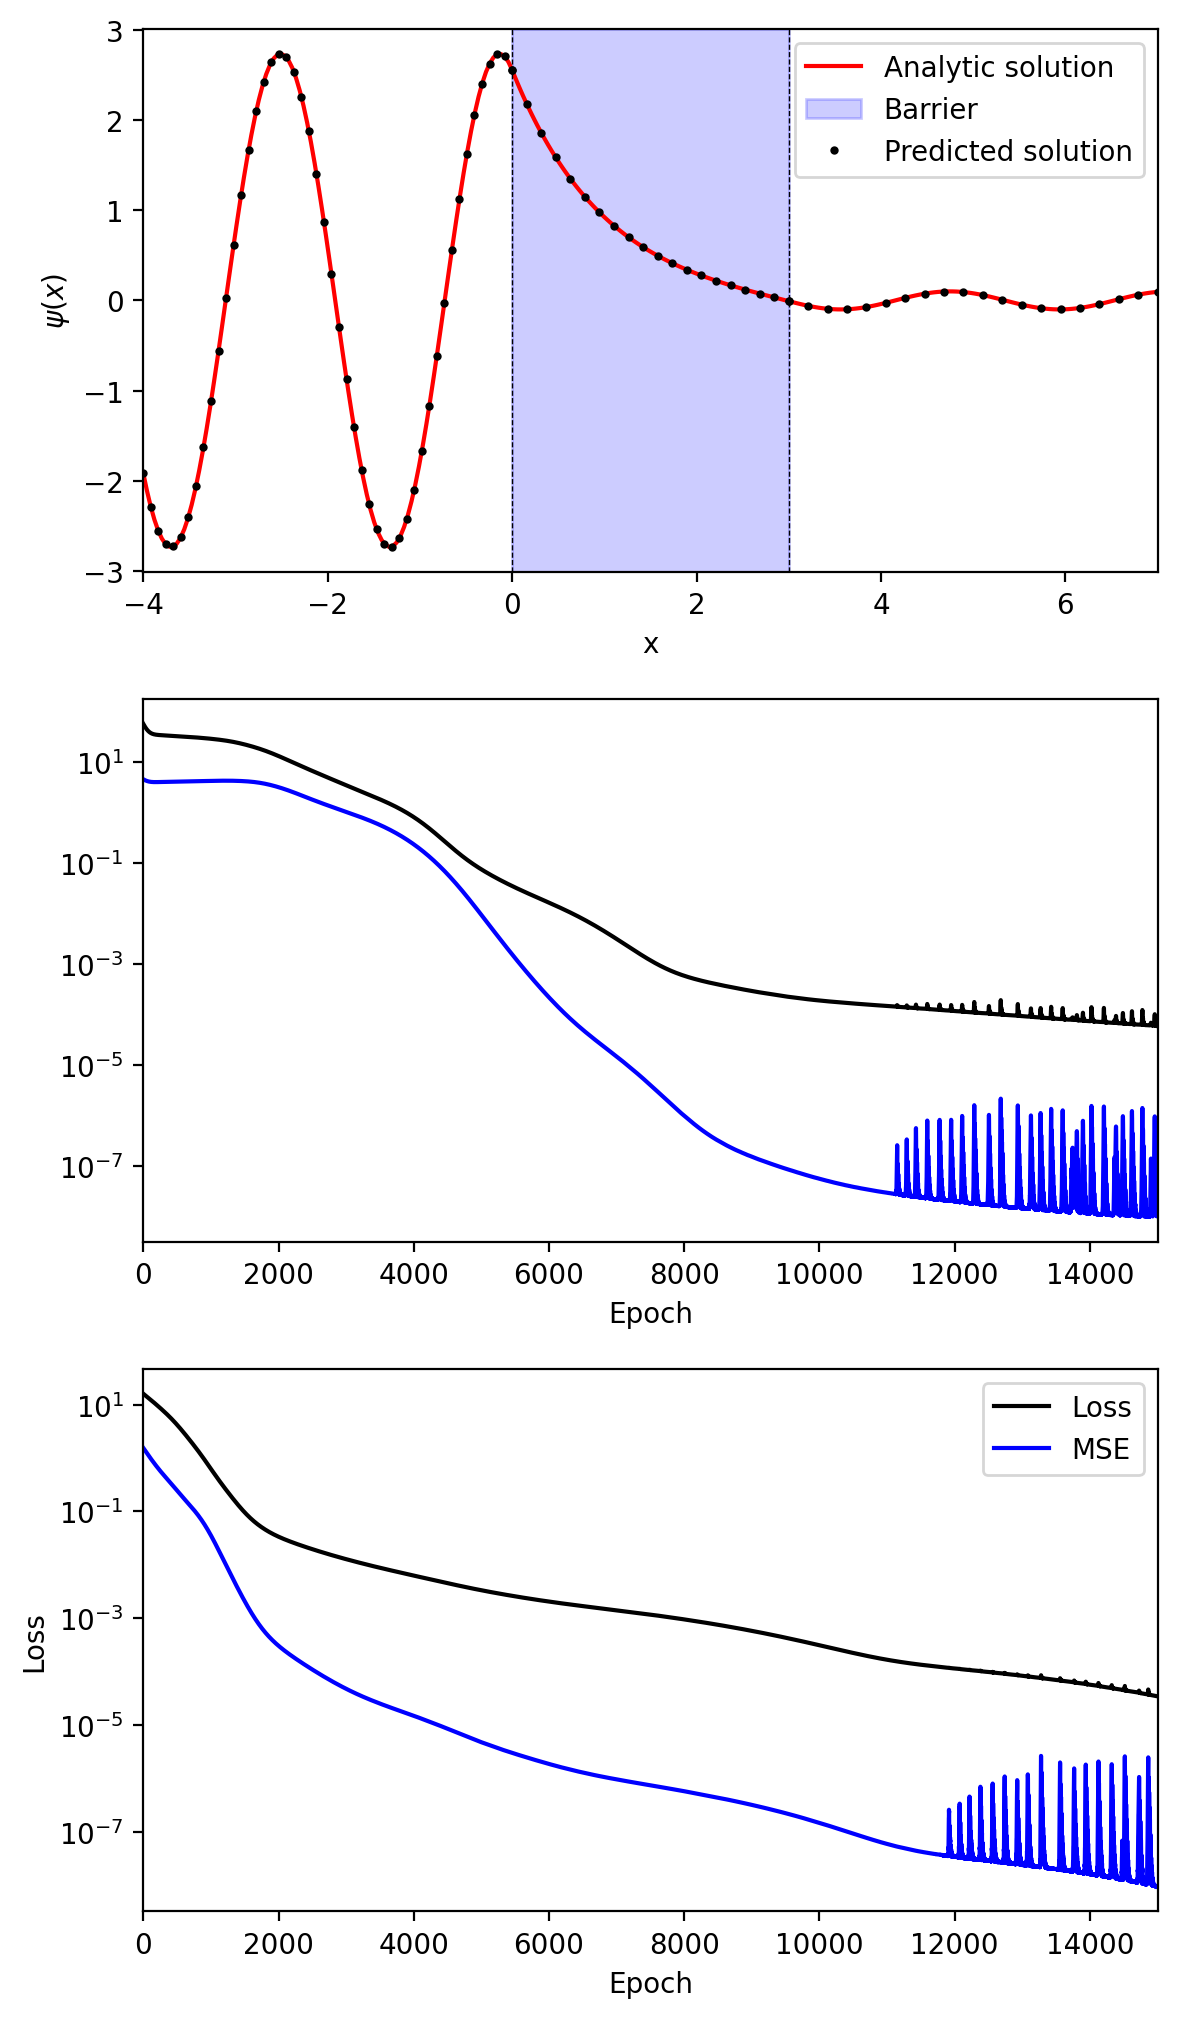

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


#variáveis da onda
#-------------------------------------------------------------------------------------------------------------
V = 4
E = 3.5
h = 1
m = 1
L1 = -4
x_0 = 0
x_a = 3
L2 = x_a+4

# número de onda
k1 = (1/h) * np.sqrt(2 * m * E)
k2 = (1/h) * np.sqrt(2 * m * (V - E))

# amplitudes das ondas
C = 0.1
F = (-0.5 * np.exp(k2 * x_a) )  *  (1j*(k1/k2) * np.exp(1j * k1 * x_a) - np.exp(1j * k1 * x_a) ) * C
G = (0.5 * np.exp(- k2 * x_a) ) * (1j*(k1/k2) * np.exp(1j * k1 * x_a) + np.exp(1j * k1 * x_a) ) * C
B = -0.5 * (-1j * (k2 / k1) * (G - F) - (G+F))
A = 0.5 * (-1j *(k2 / k1) * (G - F) + (G+F))


#treinamento na IA
class OdeSecond(nn.Module):
    def __init__(self):
        super(OdeSecond, self).__init__()
        self.dense1 = nn.Linear(1, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.sin(self.dense1(x))
        x = torch.sin(self.dense2(x))
        return self.dense3(x)

# Funções de treinamento
def train_step_one(model, optimizer, loss_fn, x_train, y_train, L, k):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([[L1]], dtype=torch.float32, requires_grad=True)                # X = L1
    y0_exact = torch.tensor([[  A * np.exp(1j * k1 * L1) + B * np.exp(-1j * k1 * L1)  ]], dtype=torch.float32)                # psi(x=L1)
    dy_dx0_exact = torch.tensor([[   k1* A * 1j* np.exp(1j * k1 * L1) - k1 * B * 1j * np.exp(-1j * k1 * L1)   ]], dtype=torch.float32)     # diff_psi( x = L1)

    xL = torch.tensor([[ 0 ]], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([[ A + B  ]], dtype=torch.float32)                # contorno x = L (observe que tanto faz usar psi1(x) ou ps2(x) em x= L = 0

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
        loss_fn(y0_NN, y0_exact)
        + loss_fn(d2y_dx2_NN, -y_NN * (k1**2))
        + loss_fn(dy_dx0_NN, dy_dx0_exact)
        + loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()



def train_step_two(model, optimizer, loss_fn, x_train, y_train, L, k):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()             # X = L1

    x0 = torch.tensor([0], dtype=torch.float32, requires_grad=True)                # X = L1
    y0_exact  = torch.tensor([  F + G ], dtype=torch.float32)     # diff_psi( x = L1)
    dy_dx0_exact = torch.tensor([ -F*k2 + G*k2   ], dtype=torch.float32)     # diff_psi( x = L1)

    xL = torch.tensor([ x_a ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([F * np.exp( -k2 * x_a) + G * np.exp( k2 * x_a)], dtype=torch.float32)                # contorno x = L (observe que tanto faz usar psi1(x) ou ps2(x) em x= L = 0

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
           loss_fn(y0_NN, y0_exact)
        +  loss_fn(d2y_dx2_NN,  y_NN * (k2**2))
        +  loss_fn(dy_dx0_NN, dy_dx0_exact)
        +  loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()

def train_step_three(model, optimizer, loss_fn, x_train, y_train, L, k):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([[x_a]], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([  C * np.exp(1j * k1 * x_a) ], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([[  1j*  C * k1 * np.exp(1j * k1 * x_a)     ]], dtype=torch.float32)

    xL = torch.tensor([[L2 ]], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([[   C * np.exp(1j * k1 * L2) ]], dtype=torch.float32)                # contorno x = L (observe que tanto faz usar psi1(x) ou ps2(x) em x= L = 0

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
        loss_fn(y0_NN, y0_exact)
        + loss_fn(d2y_dx2_NN, -y_NN * (k1**2))
        + loss_fn(dy_dx0_NN, dy_dx0_exact)
        + loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()


# Função para plotar as soluções
def plot_combined_solution(model1, model2, model3, x_train1, y_train1, x_train2, y_train2, x_train3, y_train3,  loss_values_1,  loss_values_2,  loss_values_3, mse_values_1,mse_values_2,mse_values_3):
    model1.eval()
    model2.eval()
    model3.eval()

    # Gerando os dados de teste
    x_test_tensor_1 = torch.linspace(L1, x_0, 50).unsqueeze(1)
    x_test_tensor_2 = torch.linspace(x_0, x_a, 20).unsqueeze(1)
    x_test_tensor_3 = torch.linspace(x_a, L2, 20).unsqueeze(1)

    # Obtendo as previsões dos modelos
    with torch.no_grad():
        y_pred_1 = model1(x_test_tensor_1)
        y_pred_2 = model2(x_test_tensor_2)
        y_pred_3 = model3(x_test_tensor_3)

    # Gráfico da solução combinada
    fig, ax = plt.subplots(3, 1, figsize=(6, 10))
    plt.rcParams['figure.dpi'] = 200

    ax[0].plot(x_train1, y_train1, label="Analytic solution", color="red", linewidth=1.5)
    ax[0].plot(x_train2, y_train2, color="red", linewidth=1.5)
    ax[0].plot(x_train3, y_train3, color="red", linewidth=1.5)


    #pinta a barreira
    ymin, ymax = ax[0].get_ylim()  # Obtém os limites atuais do eixo y
    x = np.linspace(x_0, x_a, 100)
    y1 = np.full_like(x, ymin)  # Limite inferior em y
    y2 = np.full_like(x, ymax)  # Limite superior em y

    ax[0].fill_between(x, y1, y2, color='blue', alpha=0.2, label='Barrier')
    ax[0].plot([x_0, x_0], [ymin, ymax], color='black', linestyle='--', linewidth=0.5)  # Contorno esquerdo
    ax[0].plot([x_a, x_a], [ymin, ymax], color='black', linestyle='--', linewidth=0.5)  # Contorno direito
    ax[0].plot(x_test_tensor_1.numpy() ,  y_pred_1.numpy() ,   '.', label="Predicted solution", color="black", markersize=4)
    ax[0].plot(x_test_tensor_2.numpy()  ,  y_pred_2.numpy()  , '.', color="black", markersize=4)
    ax[0].plot(x_test_tensor_3.numpy()  ,  y_pred_3.numpy()  , '.', color="black", markersize=4)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel(r"$\psi(x)$")
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_xlim(L1, L2)
    ax[0].legend()
    plt.tight_layout()



    ax[1].set_yscale('log')
    ax[1].plot(loss_values_1, color='black', label='Loss')
    ax[1].plot(mse_values_1, color='blue', label='MSE')
    ax[1].set_xlabel('Epoch')
    ax[1].set_xlim(0, 15000)
    plt.legend()


    ax[2].set_yscale('log')
    ax[2].plot(loss_values_2, color='black', label='Loss')
    ax[2].plot(mse_values_2, color='blue', label='MSE')
    ax[2].set_xlim(0, 15000)
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel(r'Loss')
    plt.legend()


    plt.show()



# Execução do código
if __name__ == "__main__":
    # Treinamento para x <= 0
    x_train1 = np.linspace(L1, x_0, 100)[:, np.newaxis]
    y_train1 = A * np.exp(1j*k1*x_train1) + B * np.exp(-1j*k1*x_train1)

    model1 = OdeSecond()
    optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
    loss_fn = nn.MSELoss()
    epochs = 15000


    loss_values_1 = []
    mse_values_1 = []

    for epoch in range(epochs):
        loss1, mse1= train_step_one(model1, optimizer1, loss_fn, x_train1, y_train1, L1, k1)
        loss_values_1.append(loss1)
        mse_values_1.append(mse1)
    #--------------------------------------------------------------------------------------------
    # Treinamento para 0 <= x <= x_a
    x_train2 = np.linspace(x_0, x_a, 100)[:, np.newaxis]
    y_train2 =  F*np.exp(-  k2 * x_train2) + G*np.exp( k2  * x_train2)

    model2 = OdeSecond()
    optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
    loss_values_2 = []
    mse_values_2 = []

    for epoch in range(epochs):
        loss2, mse2 = train_step_two(model2, optimizer2, loss_fn, x_train2, y_train2, x_a, k2)
        loss_values_2.append(loss2)
        mse_values_2.append(mse2)


    #--------------------------------------------------------------------------------------------
    # Treinamento para x > x_a
    x_train3 = np.linspace(x_a, L2, 100)[:, np.newaxis]
    y_train3 =  C*np.exp(1j*k1*x_train3)

    model3 = OdeSecond()
    optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
    loss_values_3 = []
    mse_values_3= []

    for epoch in range(epochs):
        loss3, mse3 = train_step_three(model3, optimizer3, loss_fn, x_train3, y_train3, L2, k1)
        loss_values_3.append(loss3)
        mse_values_3.append(mse3)

    # Plotando ambas as soluções e os valores de perda
    plot_combined_solution(model1, model2, model3, x_train1, y_train1, x_train2, y_train2, x_train3, y_train3,  loss_values_1,  loss_values_2,  loss_values_3, mse_values_1,mse_values_2,mse_values_3)
